In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from numba import jit, njit, prange
from quantecon.util import tic, toc
from scipy import stats

In [2]:
@njit
def u(c, l, cpsi, ceta):
    return np.log(c) - cpsi * (l)**(1 + ceta)/(1 + ceta)

In [62]:
class AiyagariProb:
    
    def __init__(self,
                 r=0.02,                      # interest rate
                 w=1.5,                       # wages
                 cpsi = 1,
                 ceta = 1.25,
                 cbeta=0.96,                  # discount factor
                 a_min=1e-10,
                 a_max=18,
                 a_size=100,
                 sigma_eps = 0.1,
                 z_size = 16,
                 d = 0.0,
                 rho = 0.9
                 ):
        
        #making all options class objects
        self.r, self.w, self.cpsi, self.ceta, self.cbeta = r, w, cpsi, ceta, cbeta 
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.l_size = a_size
        
        # productivity shocks
        mc = qe.rouwenhorst(z_size, d, sigma_eps, rho)
        self.P = mc.P
        self.z_size = z_size
        self.z_vals = np.exp(mc.state_values)
        
        self.a_grid = np.linspace(a_min, a_max, a_size)
        self.l_grid = np.linspace(1e-6, 1, a_size)
    
    def pack_params(self):
        return self.r, self.w, self.cpsi, self.ceta, self.cbeta, self.a_min, self.a_max, self.a_size, self.P, self.z_vals, self.a_grid, self.l_grid
        
    def bellman_operator(self):
        
        r, w, cpsi, ceta, cbeta, a_min, a_max, a_size, P, z_vals, a_grid, l_grid = self.pack_params()
        
        @njit(parallel = True)
        def T(v, v_out, pola, poll):
            for j in prange(len(z_vals)):
                z = z_vals[j]
                for i in prange(a_size):
                    x = a_grid[i]
                    max_so_far_comb = - np.inf
                    for l_i in prange(a_size):
                        l = l_grid[l_i]
                        y = (1.0 + r) * x + w * z * l
                        # Find largest x_grid index s.t. x' <= y
                        max_so_far_k = - np.inf
                        idx = np.searchsorted(a_grid, y)
                        # Step through x' with 0 <= x' <= y, find max
                        for k in range(idx):
                            x_next = a_grid[k]
                            val = u(y - x_next, l, cpsi, ceta) + cbeta * np.sum(v[k*a_size + l_i, :] * P[j, :])
                            if val > max_so_far_k:
                                max_so_far_k = val
                                a_star = k
                            
                        # for a given l check which k gives max val,
                        # then step outside 1 loop, and see if it's the max val for the l's done so far
                                
                        if max_so_far_k > max_so_far_comb:
                            max_so_far_comb = max_so_far_k
                            l_star = l_i

                        pola[i, j] = a_star
                        poll[i, j] = l_star
                        v_out[i*a_size + l_i, j] = max_so_far_comb

        return T

In [63]:
@njit
def vfi(T, v_init, pol_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pola = pol_init
    poll = np.empty_like(pola, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1
    while i < max_iter and error > tol: #a while loop works faster here than a prange loop for some reason
        T(v_in, v_out, pola, poll)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, pola, poll

In [64]:
mod = AiyagariProb()
T = mod.bellman_operator()
v_init = np.ones(((mod.a_size * mod.a_size), mod.z_size))
pol_init = np.empty((mod.a_size, mod.z_size), dtype=np.int_)

In [65]:
tic()
v_star, pola, poll = vfi(T, v_init, pol_init)
toc()

TOC: Elapsed: 0:00:29.85


29.85806894302368

In [66]:
@njit(parallel=True)
def simulate_stationary(pola,
                        poll,
                        P, 
                        a_grid,
                        l_grid,
                        z_vals,
                        i_init=10, 
                        j_init=0, 
                        num_households=100_000,
                        ts_length=1000):
    
    asset_vals = np.empty(num_households)
    elab_vals = np.empty(num_households)
    for m in prange(num_households):
        i = i_init
        j = j_init

        for t in prange(ts_length-1):
            l_i = poll[i, j] #given k_0 and z_0, which l to choose optimally
            i = pola[i, j] #transition from k_0, z_0 to k_1
            j = qe.random.draw(np.cumsum(P[j, :]))
            
        asset_vals[m] = a_grid[i]
        elab_vals[m] = z_vals[j] * l_grid[l_i]
        
    return asset_vals, elab_vals

TOC: Elapsed: 0:00:13.15


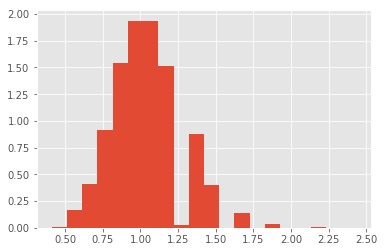

In [67]:
tic()
asset_vals, elab_vals = simulate_stationary(pola, poll, mod.P, mod.a_grid, mod.l_grid, mod.z_vals)
toc()
fig, ax = plt.subplots()
ax.hist(elab_vals, bins = 20, density=True)
plt.show()

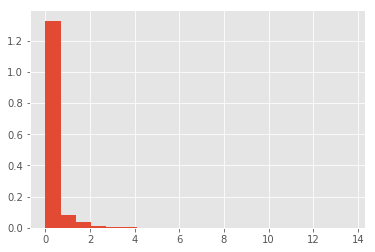

In [68]:
fig, ax = plt.subplots()
ax.hist(asset_vals, bins = 20, density=True)
plt.show()

In [14]:
@njit
def compute_stationary(T, v_init, pol_init, P, a_grid, l_grid, z_vals):
    v_out, pola, poll = vfi(T, v_init, pol_init)
    asset_vals, elab_vals = simulate_stationary(pola, poll, P, a_grid, l_grid, z_vals)
    k = asset_vals.mean()
    l = elab_vals.mean()
    return k, l

In [15]:
v_init = np.ones(((mod.a_size * mod.a_size), mod.z_size))
pol_init = np.empty((mod.a_size, mod.z_size), dtype=np.int_)
compute_stationary(T, v_init, pol_init, mod.P, mod.a_grid, mod.l_grid, mod.z_vals)

(0.03448000009984177, 1.0267041705516327)

In [16]:
A = 1.0
calpha = 0.33
cbeta = 0.96
cdelta = 0.05
cpsi = 1
ceta = 1.25


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    
    return (A * (1 - calpha) * (A * calpha / (r + cdelta))**(calpha / (1 - calpha)))

def rd(K, L):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return (A * calpha * (L / K)**(1 - calpha) - cdelta)

In [17]:
# equilibrium calculation

'''
We guess a level of interest rates
Then we calculate the capital stock and wages
Then we solve the agent's problem and solve for the supply side of effective lab and capital
Update r_0 based on it's deviation from r_1 with a simple update rule
'''

tol = 1e-5
error = tol + 1
r_0 = 0.03

while error > tol:
    # get firm's optimal w_0 for the given r_0
    w_0 = r_to_w(r_0)

    # now we can solve household problem since we have r_0 and w_0
    # we get the cpaital and effective labour supplies
    tic()
    mod = AiyagariProb(r = r_0, w = w_0)
    T = mod.bellman_operator()
    v_init = np.ones(((mod.a_size * mod.a_size), mod.z_size))
    pol_init = np.empty((mod.a_size, mod.z_size), dtype=np.int_)
    K, L = compute_stationary(T, v_init, pol_init, mod.P, mod.a_grid, mod.l_grid, mod.z_vals)
    toc()

    # get the corresponding r which the firm will pay for the supplied K and L
    r_1 = rd(K, L)

    # error between interest rates
    error = (r_0 - r_1) ** 2
    
    print('##############################')
    print(f'Interest Rate Guess: {r_0}')
    print(f'Interest Rate Firm: {r_1}')
    print(f'Error: {error}')
    print('##############################')
    
    # update rule for r_0
    r_0 = r_0  - 0.3 * 2.0 * (r_0 - r_1)

print(f'Equilibrium Interest Rate: {r_0} ; Error: {error}')

TOC: Elapsed: 0:00:52.52
##############################
Interest Rate Guess: 0.03
Interest Rate Firm: 0.35460640050391135
Error: 0.10536931524810568
##############################
TOC: Elapsed: 0:00:54.39
##############################
Interest Rate Guess: 0.22476384030234678
Interest Rate Firm: -0.029271034330179285
Error: 0.06453371752956323
##############################
TOC: Elapsed: 0:00:41.76
##############################
Interest Rate Guess: 0.07234291552283115
Interest Rate Firm: -0.013284965508281614
Error: 0.007332134009878402
##############################
TOC: Elapsed: 0:00:42.51
##############################
Interest Rate Guess: 0.020966186904163485
Interest Rate Firm: 1.0614344266972207
Error: 1.0825741580180626
##############################
TOC: Elapsed: 0:00:48.48
##############################
Interest Rate Guess: 0.6452471307799977
Interest Rate Firm: -0.040425423509984404
Error: 0.4701468517065486
##############################
TOC: Elapsed: 0:00:44.28
###########

KeyboardInterrupt: 

In [18]:
tic()
asset_vals, elab_vals = simulate_stationary(pola, poll, mod.P, mod.a_grid, mod.l_grid, mod.z_vals)
toc()

TOC: Elapsed: 0:00:12.01


12.016475200653076

In [69]:
asset_vals = np.sort(asset_vals)
tot_assets = np.sum(asset_vals)
bottom_assets = np.sum(asset_vals[0:40000])

In [70]:
bottom_assets/tot_assets

2.528241606377707e-10

In [50]:
np.sum(asset_vals[0:40000])

4.000000000000001e-06

In [51]:
np.sum(asset_vals)

1997.8181918070832